In [34]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import zipline
import pytz
import datetime as dt
from pymc3.distributions.timeseries import GaussianRandomWalk
import scipy.optimize as sco

In [2]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [3]:
x = np.linspace(0, 10, 500)
y = 4 + 2 * x + np.random.standard_normal(len(x)) * 2

In [4]:
reg = np.polyfit(x, y, 1)
print(reg)

[ 2.00818532  4.05778376]


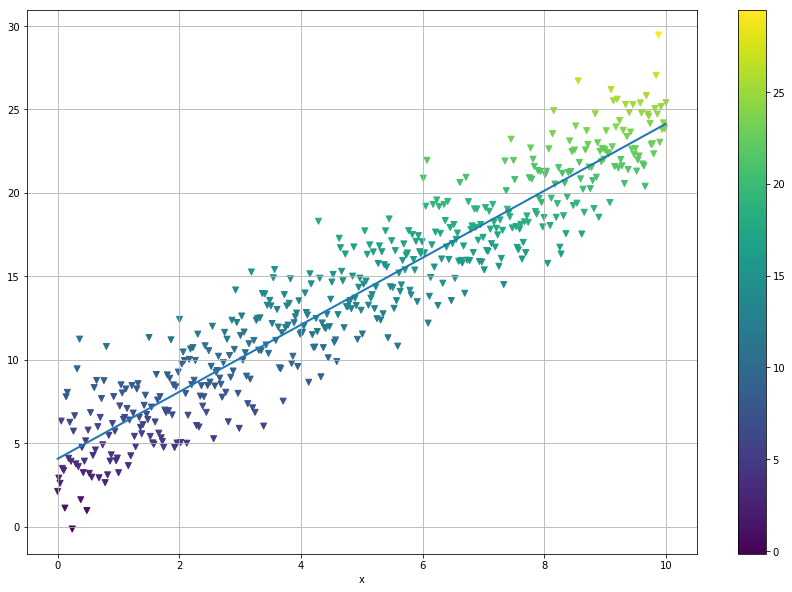

In [5]:
plt.scatter(x, y, c=y, marker='v')
plt.plot(x, reg[1] + reg[0] * x, lw=2.0)
plt.colorbar()
plt.grid(True)
plt.xlabel('x')


In [6]:
%%time
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    y_est = alpha + beta * x
    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(100, step, start=start)

Optimization terminated successfully.
         Current function value: 1073.549855
         Iterations: 16


100%|██████████| 100/100 [00:02<00:00, 44.59it/s]

         Function evaluations: 23
         Gradient evaluations: 23
CPU times: user 28.1 s, sys: 1.52 s, total: 29.6 s
Wall time: 38.2 s


In [7]:
trace[0]

{'alpha': 3.9855555625511654,
 'beta': 2.0138768800088185,
 'sigma': 2.0378683532931805,
 'sigma_interval_': -1.3627924221328174}

In [8]:
fig = pm.traceplot(trace, lines={'alpha': 3.85, 'beta': 2.02, 'sigma': 2})
plt.figure(figsize=(8,8))

In [9]:
plt.figure(figsize=(15,8))
plt.scatter(x, y, c=y, marker='v')
plt.colorbar()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(trace)):
    plt.plot(x, trace['alpha'][i] + trace['beta'][i] * x)

In [11]:
data = zipline.data.load_from_yahoo(stocks=['GLD', 'GDX'],
                                    end=dt.datetime(2014, 3, 15, 0, 0, 0, 0, pytz.utc)).dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1967 entries, 2006-05-22 to 2014-03-14
Data columns (total 2 columns):
GDX    1967 non-null float64
GLD    1967 non-null float64
dtypes: float64(2)
memory usage: 46.1 KB


In [12]:
data.plot(figsize=(8, 4))

In [13]:
data.ix[-1] / data.ix[0] - 1

GDX   -0.215999
GLD    1.038285
dtype: float64

In [14]:
data.corr()

GDX      GLD
GDX  1.00000  0.46696
GLD  0.46696  1.00000

In [16]:
data.index

DatetimeIndex(['2006-05-22', '2006-05-23', '2006-05-24', '2006-05-25',
               '2006-05-26', '2006-05-30', '2006-05-31', '2006-06-01',
               '2006-06-02', '2006-06-05',
               ...
               '2014-03-03', '2014-03-04', '2014-03-05', '2014-03-06',
               '2014-03-07', '2014-03-10', '2014-03-11', '2014-03-12',
               '2014-03-13', '2014-03-14'],
              dtype='datetime64[ns, UTC]', name=u'Date', length=1967, freq=None)

In [17]:
mpl_dates = mpl.dates.date2num(data.index.to_pydatetime())

In [18]:
mpl_dates

array([ 732453.,  732454.,  732455., ...,  735304.,  735305.,  735306.])

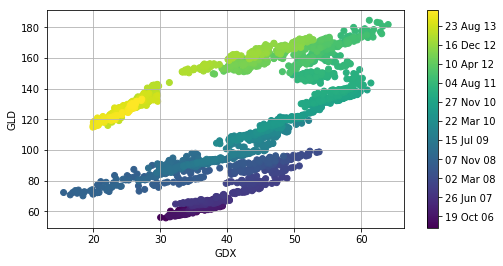

In [19]:
plt.figure(figsize=(8, 4))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates, marker='o')
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250), format=mpl.dates.DateFormatter('%d %b %y'))

In [20]:
%%time
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    y_est = alpha + beta * data['GDX'].values
    
    likelihood = pm.Normal('GLD', mu=y_est, sd=sigma, observed=data['GLD'].values)
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(100, step, start=start)

         Current function value: 16114.770709
         Iterations: 33
         Function evaluations: 107
         Gradient evaluations: 96


100%|██████████| 100/100 [01:37<00:00,  1.02it/s]

CPU times: user 1min 56s, sys: 3.74 s, total: 1min 59s
Wall time: 2min 2s


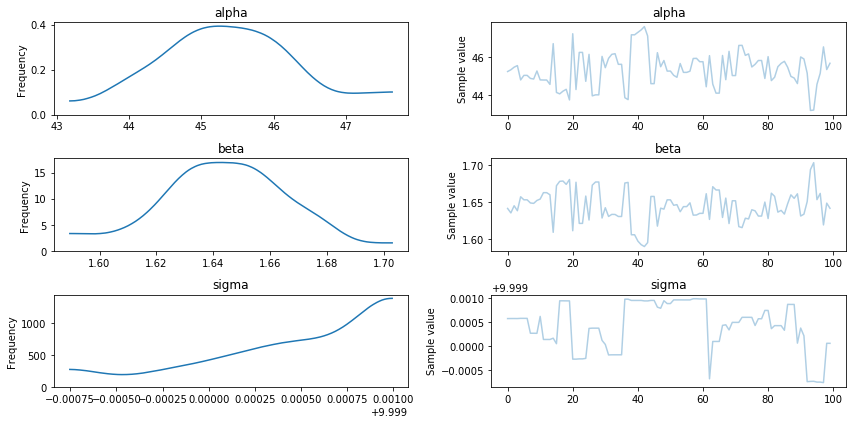

In [22]:
fig = pm.traceplot(trace)
plt.figure(figsize=(8,8))

In [24]:
plt.figure(figsize=(15,8))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates, marker='v')
plt.colorbar()
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
for i in range(len(trace)):
    plt.plot(data['GDX'], trace['alpha'][i] + trace['beta'][i] * data['GDX'])

In [36]:
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = pm.Exponential('sigma_alpha', 1. / .02, testval=.1)
    sigma_beta  = pm.Exponential('sigma_beta' , 1. / .02, testval=.1)

In [31]:
subsample_alpha = 50
subsample_beta = 50

with model_randomwalk:
    alpha = GaussianRandomWalk('alpha', sigma_alpha**-2, shape=len(data) / subsample_alpha)
    beta  = GaussianRandomWalk('beta' , sigma_beta**-2 , shape=len(data) / subsample_beta)
    
    alpha_r = np.repeat(alpha, subsample_alpha)
    beta_r = np.repeat(beta, subsample_beta)

In [32]:
len(data.dropna().GDX.values)

1967

In [33]:
with model_randomwalk:
    regression = alpha_r + beta_r * data.GDX.values[:1950]
    
    sd = pm.Uniform('sd', 0, 20)
    likelihood = pm.Normal('GLD', mu=regression, sd=sd, observed=data.GLD.values[:1950])

In [35]:
with model_randomwalk:
    start = pm.find_MAP(vars=[alpha, beta], fmin=sco.fmin_l_bfgs_b)
    
    step = pm.NUTS(scaling=start)
    trac_rw = pm.sample(100, step, start=start)

100%|██████████| 100/100 [04:48<00:00,  2.89s/it]


In [38]:
np.shape(trac_rw['alpha'])

(100, 39)

In [39]:
part_dates = np.linspace(min(mpl_dates), max(mpl_dates), 39)
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.plot(part_dates, np.mean(trac_rw['alpha'], axis=0), 'b', lw=2.5, label='alpha')
for i in range(45, 55):
    plt.plot(part_dates, trac_rw['alpha'][i], 'b-.', lw=.75)
plt.xlabel('date')
plt.ylabel('alpha')
plt.axis('tight')
plt.grid(True)
plt.legend(loc=2)
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d %b %y'))
ax2 = ax1.twinx()
plt.plot(part_dates, np.mean(trac_rw['beta'], axis=0), 'r', lw=2.5, label='beta')
for i in range(45, 55):
    plt.plot(part_dates, trac_rw['beta'][i], 'r-.', lw=.75)
plt.ylabel('beta')
plt.legend(loc=4)
fig.autofmt_xdate()

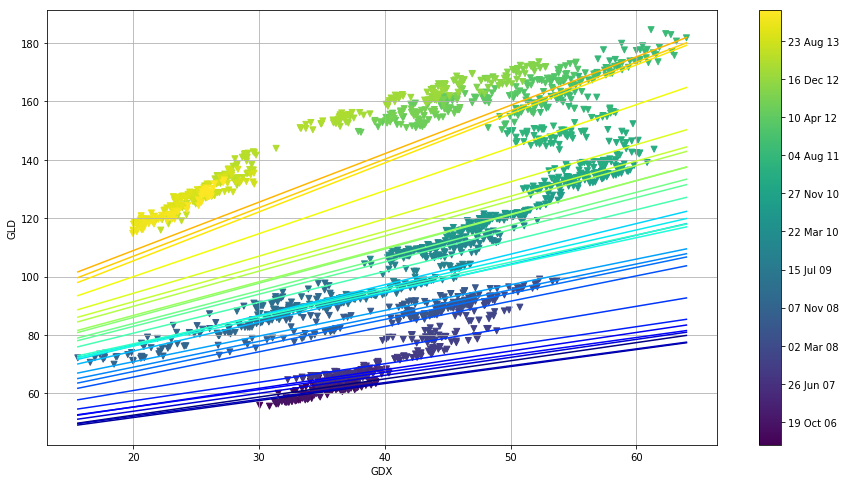

In [40]:
plt.figure(figsize=(15, 8))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates, marker='v')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250), format=mpl.dates.DateFormatter('%d %b %y'))
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
x = np.linspace(min(data['GDX']), max(data['GDX']))
for i in range(29):
    alpha_rw = np.mean(trac_rw['alpha'].T[i])
    beta_rw = np.mean(trac_rw['beta'].T[i])
    plt.plot(x, alpha_rw + beta_rw * x, color=plt.cm.jet(256 * i / 39))